In [1]:
!git clone https://github.com/zhu-xlab/DOFA.git
%cd /content/DOFA
!pip install -r requirements.txt
!python /content/DOFA/checkpoints/download_weights.py

Cloning into 'DOFA'...
remote: Enumerating objects: 33204, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 33204 (delta 84), reused 73 (delta 59), pack-reused 33087 (from 3)
Receiving objects: 100% (33204/33204), 1.00 GiB | 16.95 MiB/s, done.
Resolving deltas: 100% (751/751), done.
/content/DOFA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: rasterio
    Found existing installation: rasterio 1.4.4
    Uninstalling rasterio-1.4.4:
      Successfully uninstalled rasterio-1.4.4
  Attempting uninstall: timm
    Found existing installation: timm 1.0.22
    Uninstalling timm-1.0.22:
      Successfully uninstalled timm-1.0.22
DOFA_ViT_ba

In [2]:

from functools import partial
from wave_dynamic_layer import Dynamic_MLP_OFA, Dynamic_MLP_Decoder
from operator import mul
from torch.nn.modules.utils import _pair
from torch.nn import Conv2d, Dropout
import numpy as np

import torch
import torch.nn as nn
import pdb
import math
from functools import reduce
import json

from timm.models.vision_transformer import PatchEmbed, Block

class OFAViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, drop_rate=0.,
                 embed_dim=1024, depth=24, num_heads=16, wv_planes=128, num_classes=45,
                 global_pool=True, mlp_ratio=4., norm_layer=nn.LayerNorm):
        super().__init__()

        self.wv_planes = wv_planes
        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = norm_layer
            embed_dim = embed_dim
            self.fc_norm = norm_layer(embed_dim)
        else:
            self.norm = norm_layer(embed_dim)

        self.patch_embed = Dynamic_MLP_OFA(wv_planes=128, inter_dim=128, kernel_size=16, embed_dim=embed_dim)
        self.num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])

        self.head_drop = nn.Dropout(drop_rate)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()


    def forward_features(self, x, wave_list):
        # embed patches
        wavelist = torch.tensor(wave_list, device=x.device).float()
        self.waves = wavelist

        x, _ = self.patch_embed(x, self.waves)

        x = x + self.pos_embed[:, 1:, :]
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for block in self.blocks:
            x = block(x)

        # print(x.shape)
        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]
        # print(outcome.shape)
        return x

    def forward_head(self, x, pre_logits=False):
        x = self.head_drop(x)
        return x if pre_logits else self.head(x)

    def forward(self, x, wave_list):
        x = self.forward_features(x, wave_list)
        x = self.forward_head(x)
        return x

def vit_base_patch16(**kwargs):
    model = OFAViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [3]:
import torch

check_point = torch.load('./checkpoints/DOFA_ViT_base_e100.pth')
vit_model = vit_base_patch16(global_pool=False)
msg = vit_model.load_state_dict(check_point, strict=False)
vit_model = vit_model.cuda()

In [4]:
import torch
import torch.nn as nn
import numpy as np


class PrithviSegmentationModel(nn.Module):
    def __init__(self, img_size=224, num_classes=2):
        super(PrithviSegmentationModel, self).__init__()
        self.image_size = img_size
        self.encoder = vit_model

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # Upsample to match the final size
            nn.Conv2d(64, num_classes, kernel_size=1)
        )


    def forward(self, x):
        outputs = self.encoder.forward_features(x, wave_list=[0.515, 0.549, 0.680, 0.885])

        sequence_output = outputs[:, 1:] # avoid cls token
        hidden_size = sequence_output.shape[-1]
        feature_map = sequence_output.view(-1, int(self.image_size/16), int(self.image_size/16), hidden_size).permute(0, 3, 1, 2)

        y_pred = self.decoder(feature_map)
        return y_pred

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrithviSegmentationModel().to(device)
x = torch.rand(3, 4, 224, 224).to(device)  # (b, c, h, w)
y_pred = model(x)  # (b, num_classes, h, w)
y_pred.shape

torch.Size([3, 2, 224, 224])

# Training

In [5]:
import tensorflow as tf
import os
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np

In [6]:
def input_pipeline(filename, batch_size, is_shuffle=True, is_train=True, is_repeat=True):
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([400*400*4], dtype=tf.int64),
        'label': tf.io.FixedLenFeature([400*400*1], dtype=tf.int64),
    }

    def _parse_function(example_proto):
        feature_dict = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(feature_dict['image_raw'], [400, 400, 4])
        image = tf.cast(image, tf.float32)

        label = tf.reshape(feature_dict['label'], [400, 400, 1])
        label = tf.cast(label, tf.float32)

        image_label = tf.concat([image, label], axis=-1)
        image_label = tf.image.resize(image_label, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        if is_train:
            image_label = tf.image.rot90(image_label, tf.random.uniform([], 0, 5, dtype=tf.int32))
            image_label = tf.image.random_flip_left_right(image_label)
            image_label = tf.image.random_flip_up_down(image_label)

        image = image_label[:, :, :4]
        image = image/10000

        label = image_label[:, :, -1]
        label = tf.cast(label, tf.int64)

        image = tf.transpose(image, perm=[2, 0, 1])

        return image, label

    dataset = tf.data.TFRecordDataset(filename)
    if is_repeat:
        dataset = dataset.repeat()
    dataset = dataset.map(_parse_function)
    if is_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    batch = dataset.batch(batch_size=batch_size)
    return batch

In [7]:
folder = ['/content/drive/MyDrive/ice_cloud/l8ps_ds_2', '/content/drive/MyDrive/ice_cloud/l8ps_ds_3',
          '/content/drive/MyDrive/ice_cloud/l8ps_ds_4', '/content/drive/MyDrive/ice_cloud/l8ps_ds_5',
          '/content/drive/MyDrive/ice_cloud/l8ps_ds_6']
filenames = [os.path.join(folder[0], f) for f in os.listdir(folder[0]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[1], f) for f in os.listdir(folder[1]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[2], f) for f in os.listdir(folder[2]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[3], f) for f in os.listdir(folder[3]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[4], f) for f in os.listdir(folder[4]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]

filenames

['/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230308_212634_27_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230325_103503_19_240c.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230329_033637_63_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230402_144322_97_2402.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230417_072528_39_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094613_93_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094636_32_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230420_143108_00_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192205_75_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192219_98_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230503_122053_44_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230515_223754_57_240c.tfrecords',
 '/content/drive/MyDrive/ice

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_process():
    train_ds = input_pipeline(filenames, 64, is_repeat=False)

    for i in range(20):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (images, labels) in enumerate(train_ds):

            images, labels = images.numpy(), labels.numpy()  # Step 1: Convert to NumPy
            images, labels = torch.tensor(images), torch.tensor(labels)  # Step 2: Convert to PyTorch tensors
            images, labels = images.to(device), labels.to(device)  # Step 3: Move to the specified device

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            # print(loss)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            total_samples += labels.size(0)
            correct_predictions_batch = (predicted == labels).sum().item()/((labels.size(0)*224*224))
            print(batch_idx, loss.item(), correct_predictions_batch)


        epoch_loss = running_loss/batch_idx
        epoch_accuracy = correct_predictions / (total_samples*224*224) * 100
        print(f"Epoch [{i+1}/{100}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        # torch.save(model.state_dict(), 'DOFA.pth')

train_process()

# Testing

In [9]:
import os
folder_path = '/content/drive/MyDrive/ice_cloud/test_ds/dataset'
imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs.sort()

folder_path = '/content/drive/MyDrive/ice_cloud/test_ds2/dataset'
imgs2 = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs2.sort()
imgs = imgs+imgs2
imgs

['/content/drive/MyDrive/ice_cloud/test_ds/dataset/2022-04-15_strip_5573346_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-08-31_strip_6747657_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-09_strip_6763305_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-14_strip_6774056_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-20_strip_6786319_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-21_strip_6788017_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-24_strip_6793653_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-27_strip_6800261_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-06_strip_6818915_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-08_strip_6823217_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-13_strip_6833728_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/202

In [10]:
from osgeo import gdal, osr

def tif2array(input_file):
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=int)

    for b in range(dataset.RasterCount):
        band = dataset.GetRasterBand(b + 1)
        image[:, :, b] = band.ReadAsArray()

    return image

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/drive/MyDrive/ice_cloud/github_code/DOFA.pth", map_location=device))
model.to(device)

PrithviSegmentationModel(
  (encoder): OFAViT(
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (patch_embed): Dynamic_MLP_OFA(
      (weight_generator): TransformerWeightGenerator(
        (transformer_encoder): TransformerEncoder(
          (layers): ModuleList(
            (0): TransformerEncoderLayer(
              (self_attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
              )
              (linear1): Linear(in_features=128, out_features=2048, bias=True)
              (dropout): Dropout(p=False, inplace=False)
              (linear2): Linear(in_features=2048, out_features=128, bias=True)
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (dropout1): Dropout(p=False, inplace=False)
              (dropout2): Dropout(p=False, inplace=False)
            )
    

In [12]:
def clip_center(img, clip_height, clip_width):
    """
    Clips the center part of the image.

    Parameters:
    - img: 2D or 3D NumPy array representing the image.
    - clip_height: Height of the central clip.
    - clip_width: Width of the central clip.

    Returns:
    - Clipped center part of the image as a NumPy array.
    """
    # Get image dimensions
    img_height, img_width = img.shape[:2]

    # Calculate the center coordinates
    center_y, center_x = img_height // 2, img_width // 2

    # Define the starting and ending points for the clipping
    start_y = max(center_y - clip_height // 2, 0)
    end_y = min(center_y + clip_height // 2, img_height)
    start_x = max(center_x - clip_width // 2, 0)
    end_x = min(center_x + clip_width // 2, img_width)

    # Return the clipped center part
    return img[start_y:end_y, start_x:end_x]

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


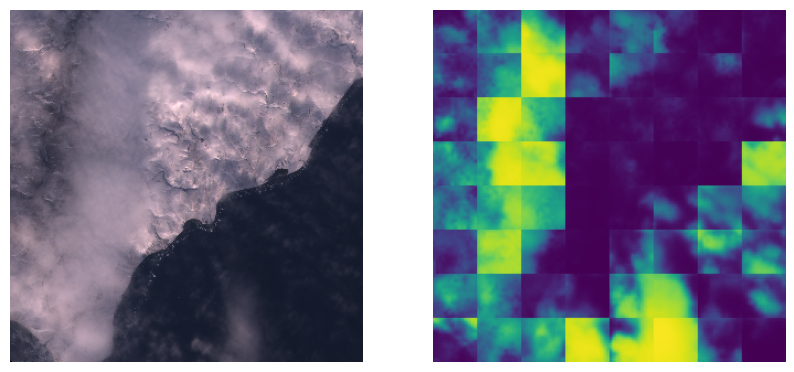

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf

for img_path in imgs[2:3]:
    img = tif2array(img_path)
    img = clip_center(img, 3200, 3200)
    img = img/10000

    img = tf.reshape(img, [1, 3200, 3200, 4])

    patch_size = 400
    stride = 400
    output_shape = (img.shape[1], img.shape[2])

    # Initialize an empty array for storing the full prediction
    full_prediction = np.zeros(output_shape)

    # Iterate over the image with a sliding window
    for i in range(0, img.shape[1], stride):
        for j in range(0, img.shape[2], stride):
            patch = img[:, i:i+patch_size, j:j+patch_size, :]

            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
                patch = tf.image.resize(patch, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                patch = tf.transpose(patch, perm=[0, 3, 1, 2])
                patch = torch.tensor(patch.numpy())
                patch = patch.to(device)
                patch = patch[:, :, :, :]
                pred = model(patch.float())
                pred = tf.transpose(pred.cpu().detach().numpy(), perm=[0, 2, 3, 1])
                pred = tf.nn.softmax(pred, axis=-1)
                pred = tf.image.resize(pred, [400, 400], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                full_prediction[i:i+patch_size, j:j+patch_size] = pred[0, :, :, 1]

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img[0, ::10, ::10, 2::-1], vmin=0, vmax=1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(full_prediction, vmin=0, vmax=1)
